## This is my attemp at the solution of the "School budget" competition of drivendata 

The competition is now closed, but can be found at https://www.drivendata.org/competitions/4/box-plots-for-education/page/121/

Between other ML techniques, I used a pipeline, a one versus rest classifier and a Hashing vectorizer

In [200]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MaxAbsScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics.scorer import make_scorer

In [201]:
df=pd.read_csv("TrainingData.csv",index_col=0)

In [202]:
df.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

In [204]:
df.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


FTE =  Stands for "full-time equivalent". If the budget item is associated to an employee, this number tells us the percentage of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee.

Total= Stands for the total cost of the expenditure. This number tells us how much the budget item cost.

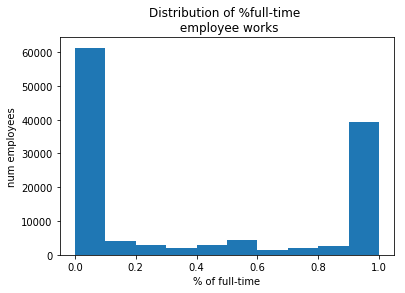

In [205]:
plt.hist(df["FTE"].dropna(),range=(0,1))
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')
plt.show()

.dropna() serve per togliere missing values

In [206]:
df.dtypes.value_counts()

object     23
float64     2
dtype: int64

Text(0,0.5,'Number of unique values')

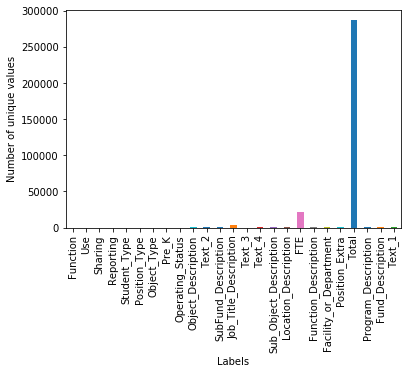

In [207]:
num_unique_labels=df.apply(pd.Series.nunique)
num_unique_labels.plot(kind="bar")
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

In [208]:
dfmt=df.drop(["Total","FTE","Job_Title_Description","Text_1"],axis=1)
dfmt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 21 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
Function_Description      342195 non-null object
Facility_or_Department    53886 non-null object
Positi

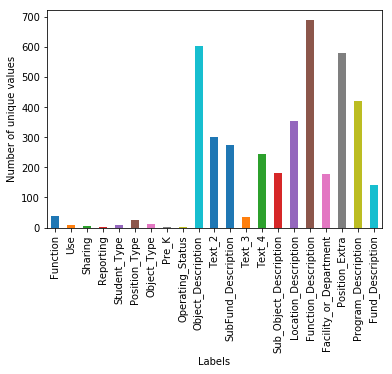

Function                   37
Use                         8
Sharing                     5
Reporting                   3
Student_Type                9
Position_Type              25
Object_Type                11
Pre_K                       3
Operating_Status            3
Object_Description        602
Text_2                    301
SubFund_Description       274
Text_3                     34
Text_4                    244
Sub_Object_Description    182
Location_Description      354
Function_Description      687
Facility_or_Department    179
Position_Extra            580
Program_Description       421
Fund_Description          141
dtype: int64


In [209]:
num_unique_labels=dfmt.apply(pd.Series.nunique)
num_unique_labels.plot(kind="bar")
plt.xlabel('Labels')
plt.ylabel('Number of unique values')
plt.show()
print num_unique_labels

NOTA: useremo "log_loss" come metrica per misurare la bontà del nostro modello. Si può implementare ad esempio come sklearn.metrics.log_loss

In [210]:
labels = ['Function',
          'Use',
          'Sharing',
          'Reporting',
          'Student_Type',
          'Position_Type',
          'Object_Type', 
          'Pre_K',
          'Operating_Status']
labels.sort()

features = [c for c in df.columns if c not in labels]

nfeatures = ['FTE', "Total"]

tfeatures = [c for c in features if c not in nfeatures] 

sample_size=df.shape[0]

X=df[features]
X=X[:sample_size]
y=pd.get_dummies(df[labels])
y=y[:sample_size]
print X.shape,y.shape

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1)
print X_train.shape,X_test.shape,y_train.shape,y_test.shape

(400277, 16) (400277, 104)
(300207, 16) (100070, 16) (300207, 104) (100070, 104)


In [211]:
def combine_text_columns(data_frame):
    data_frame=data_frame[tfeatures]
    data_frame.fillna("", inplace=True)
    return data_frame.apply(lambda x : " ".join(x), axis=1)
    

get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[nfeatures], validate=False)

In [212]:
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

vec=HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,non_negative=True, norm=None, binary=False,ngram_range=(1, 2))
pip_num=Pipeline([("num_sel",get_numeric_data),("imputer",Imputer())])
pip_text=Pipeline([("text_sel",get_text_data),("vectorizer",vec),('dim_red', SelectKBest(chi2, 300))])
union=FeatureUnion([("num",pip_num),("text",pip_text)])
pip=Pipeline([("feat_union",union),('scale', MaxAbsScaler()),('clf', OneVsRestClassifier(LogisticRegression()))])

In [213]:
pip.fit(X_train,y_train.values)

/anaconda2/lib/python2.7/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


Pipeline(memory=None,
     steps=[('feat_union', FeatureUnion(n_jobs=1,
       transformer_list=[('num', Pipeline(memory=None,
     steps=[('num_sel', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x1a0d5decf8>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
 ...=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1))])

In [214]:
holdout = pd.read_csv("TestData.csv", index_col=0)
pred=pip.predict_proba(holdout)

/anaconda2/lib/python2.7/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


In [215]:
dic=["Function_","Object_Type_","Operating_Status_","Position_Type_","Pre_K_","Reporting_","Sharing_","Student_Type_","Use_"]

def sub(s):
    for i in dic:
        s=s.replace(i,i+"_")
    return s

In [216]:
pd.get_dummies(df[labels]).columns
nc=ln=[sub(i) for i in pd.get_dummies(df[labels]).columns]
print nc
df_pred = pd.DataFrame(columns=nc,index=holdout.index,data=pred)
df_pred.to_csv("predictions.csv")
print pred.shape
df_pred.head()

['Function__Aides Compensation', 'Function__Career & Academic Counseling', 'Function__Communications', 'Function__Curriculum Development', 'Function__Data Processing & Information Services', 'Function__Development & Fundraising', 'Function__Enrichment', 'Function__Extended Time & Tutoring', 'Function__Facilities & Maintenance', 'Function__Facilities Planning', 'Function__Finance, Budget, Purchasing & Distribution', 'Function__Food Services', 'Function__Governance', 'Function__Human Resources', 'Function__Instructional Materials & Supplies', 'Function__Insurance', 'Function__Legal', 'Function__Library & Media', 'Function__NO_LABEL', 'Function__Other Compensation', 'Function__Other Non-Compensation', 'Function__Parent & Community Relations', 'Function__Physical Health & Services', 'Function__Professional Development', 'Function__Recruitment', 'Function__Research & Accountability', 'Function__School Administration', 'Function__School Supervision', 'Function__Security & Safety', 'Function_

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
180042,0.110353,0.002092,0.000033,0.000170,0.010813,0.000253,0.066291,0.040207,0.036138,0.000114,...,0.009267,0.878455,0.004208,0.012396,0.915933,0.007438,0.062397,0.048509,0.011219,0.000278
28872,0.000216,0.001129,0.000332,0.000172,0.003571,0.000197,0.999806,0.002384,0.000761,0.000126,...,0.006299,0.779054,0.004496,0.000848,0.000871,0.004949,0.460868,0.022410,0.730760,0.000210
186915,0.501319,0.001980,0.000035,0.000579,0.001863,0.000119,0.027159,0.003135,0.026595,0.000081,...,0.037960,0.783861,0.004305,0.017288,0.771549,0.032992,0.061023,0.015396,0.006695,0.000009
412396,0.501310,0.001980,0.000035,0.000579,0.001863,0.000119,0.027158,0.003135,0.026594,0.000081,...,0.037959,0.783840,0.004305,0.017287,0.771537,0.032993,0.061028,0.015397,0.006695,0.000009
427740,0.001924,0.003713,0.000669,0.000101,0.024159,0.000357,0.026524,0.000201,0.000617,0.000092,...,0.014505,0.956130,0.305909,0.014937,0.021746,0.405390,0.042824,0.027616,0.079745,0.000206


In [171]:
BOX_PLOTS_COLUMN_INDICES = [list(range(37)),
                            list(range(37, 48)),
                            list(range(48, 51)),
                            list(range(51, 76)),
                            list(range(76, 79)),
                            list(range(79, 82)),
                            list(range(82, 87)),
                            list(range(87, 96)),
                            list(range(96, 104))]


def multi_multi_log_loss(predicted,
                          actual,
                          class_column_indices=BOX_PLOTS_COLUMN_INDICES,
                          eps=1e-15):
    """ Multi class version of Logarithmic Loss metric as implemented on
        DrivenData.org
    """
    class_scores = np.ones(len(class_column_indices), dtype=np.float64)

    # calculate log loss for each set of columns that belong to a class:
    for k, this_class_indices in enumerate(class_column_indices):
        # get just the columns for this class
        preds_k = predicted[:, this_class_indices].astype(np.float64)

        # normalize so probabilities sum to one (unless sum is zero, then we clip)
        preds_k /= np.clip(preds_k.sum(axis=1).reshape(-1, 1), eps, np.inf)

        actual_k = actual[:, this_class_indices]

        # shrink predictions so
        y_hats = np.clip(preds_k, eps, 1 - eps)
        sum_logs = np.sum(actual_k * np.log(y_hats))
        class_scores[k] = (-1.0 / actual.shape[0]) * sum_logs

    return np.average(class_scores)

In [172]:
log_loss_scorer = make_scorer(multi_multi_log_loss)
print(log_loss_scorer(pip, X_test, y_test.values))

/anaconda2/lib/python2.7/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


3.1485618821210437


In [152]:
print(y_test.shape)

(10000, 104)
